# 縁故主義経済シミュレーション

(Version 0.0.1)

縁故主義(ネポティズムとかクローニー・キャピタリズムとか)よりそうでない非縁故主義のほうが投資ボリュームが増えるというのを経済モデルまたはシミュレーションで示せないかと考えた。

縁故主義だと、商店のリスクがまるわかりのため小さいリスクで投資を引き上げる。縁故主義でないと、わりとリスクがあっても投資が続く。これが広がると、縁故主義でないほう が経済も大きくなって機会も増え、投資ボリュームが増えてもやっていける。…みたいなことが起きると考えた。

これを Gemini 2.5 Flash さんに頼んで Python シミュレーションにしてもらった。はじめて Canvas 機能を使って聞いてみた。私も修正に協力しながらプログラムを組み上げていった。

結論としては、投資環境が良いときは非縁故主義が勝つことが示せた。逆に言えば投資環境が普通以下の場合は、縁故主義が勝ってしまって、もともと私が示したかったようにはいかなかった。

いちおう Gemini さんとの会話は↓に共有しておく。Canvas の内容がうまく見れない感じだが。

https://g.co/gemini/share/31fe5a537ee9

## 実験1

まず簡単なモデルを導入しよう。縁故主義だと完全に情報がわかり非縁故主義だと不完全にしかわからない…というのは私にはモデル化できないので、単純に縁故主義だとリスク許容度が小さく、非縁故主義だとリスク許容度が大きいというプログラムにして、経済がどのように大きくなるかを見て見る。

In [1]:
import random
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

# --- シミュレーションパラメータ ---
RUNS = 20   #シミュレーション実行回数

NUM_INVESTORS = 100  # 投資家数
NUM_BUSINESSES = 200 # 事業数
INITIAL_TOTAL_CAPITAL = 100000 # 経済全体の初期総資金
NUM_PERIODS = 30     # シミュレーション期間（期）

# 事業のリスクとリターンに関するパラメータ
# リスクレベル（0:低リスク ～ 1:高リスク）
def business_risk_levels ():
    return [random.random() for _ in range(NUM_BUSINESSES)]
BUSINESS_RISK_LEVELS = business_risk_levels()

# 成功確率 = 1 - リスクレベル
def success_probability (risk_levels):
    return [1 - risk for risk in risk_levels]
SUCCESS_PROBABILITY = success_probability(BUSINESS_RISK_LEVELS)

# 成功時のリターン倍率 (投資額に対する回収+利益)
# リスクが高いほど成功時のリターンも大きいと仮定
def return_multiplier (risk_levels):
#    return [1.2 + risk * 1.5 for risk in risk_levels]
    return [1.0 + risk * 1.5 for risk in risk_levels]
RETURN_MULTIPLIER = return_multiplier(BUSINESS_RISK_LEVELS)

# 投資家の判断に関するパラメータ
# 縁故主義シナリオでの安全投資閾値（このリスク以下の事業に優先投資）
NEPOTISM_SAFE_THRESHOLD = 0.3
# 非縁故主義シナリオでの安全投資閾値（このリスク以下の事業に優先投資）
NON_NEPOTISM_SAFE_THRESHOLD = 0.7
# 安全投資閾値（このリスク以下の事業に優先投資）
SAFE_THRESHOLD = NEPOTISM_SAFE_THRESHOLD
# リスク回避度（閾値以上のリスクへの投資を控える度合い）
RISK_AVERSION = 0.8
#RISK_AVERSION = 1.0

# 事業収益環境
PROFIT_RISK_MAG = 0.5  # 0.5:良い 2.0:悪い


# --- シミュレーション関数 ---

def run_simulation(scenario="nepotism"):
    """
    経済シミュレーションを実行する関数

    Args:
        scenario (str): "nepotism" または "non_nepotism"

    Returns:
        list: 各期末の経済全体の総資金のリスト
    """
    total_capital = INITIAL_TOTAL_CAPITAL
    capital_history = [total_capital] # 各期の総資金を記録

    #print(f"--- シナリオ: {scenario} ---")
    #print(f"初期総資金: {total_capital:.2f}")

    for period in range(NUM_PERIODS):
        # 各投資家の利用可能資金を均等に分割（単純化のため）
        investor_capital = total_capital / NUM_INVESTORS
        if investor_capital <= 0:
            print(f"期 {period+1}: 総資金が0以下になりました。"
                  + "シミュレーションを終了します。")
            capital_history.append(total_capital)
            break

        # その期に事業に投資される総額
        period_total_investment = 0
        # 事業ごとの投資受け入れ額
        business_investments = [0] * NUM_BUSINESSES

        # 投資ラウンド
        for investor_id in range(NUM_INVESTORS):
            available_to_invest = investor_capital
            invested_count = 0

            # 投資判断ロジック
            # 安全な事業を優先し、リスク回避度に応じて高リスクを避ける
            potential_businesses = list(range(NUM_BUSINESSES))
            random.shuffle(potential_businesses) # ランダムな順序で検討
            for business_id in potential_businesses:
                risk = BUSINESS_RISK_LEVELS[business_id]
                # リスクは正確に把握していると仮定
                # （ここでは単純化のため、全事業のリスクを正確に知っているが、
                #   縁故主義は安全志向が強いとモデル化）
                # より厳密には、一部の縁故事業のリスク情報だけ完全にするなどの
                # 工夫が必要だが、ここでは安全志向の投資判断で代替
                investment_amount = 0
                if risk <= SAFE_THRESHOLD:
                    # 低リスク事業には積極的に投資
                    # リスクが低いほど多く投資
                    investment_amount = available_to_invest * (1 - risk)
                else:
                    # 高リスク事業への投資はリスク回避度に応じて控える
                    investment_amount = available_to_invest * (1 - risk) \
                        * (1 - RISK_AVERSION)

                if investment_amount > 0:
                     # 利用可能な資金を超えないように調整
                    actual_investment = min(investment_amount,
                                            available_to_invest)
                    business_investments[business_id] += actual_investment
                    period_total_investment += actual_investment
                    available_to_invest -= actual_investment
                    invested_count += 1
                    if available_to_invest <= 0:
                        break # 資金が尽きたら次の投資家へ

        # 事業の成果判定と資金更新
        period_return = 0 # その期に事業から回収される総額（投資元本＋利益）
        for business_id in range(NUM_BUSINESSES):
            if business_investments[business_id] > 0:
                # 事業が成功するかどうかを確率的に判定
                if random.random() < SUCCESS_PROBABILITY[business_id] \
                   ** PROFIT_RISK_MAG:
                    # 成功した場合：投資額を回収し、リターンを得る
                    period_return += business_investments[business_id] \
                        * RETURN_MULTIPLIER[business_id]
                else:
                    # 失敗した場合：投資額は失われる
                    pass # period_return は増加しない

        # 期末の総資金 = 期首総資金 - その期の総投資額 \
        #    + その期の事業からの総回収額
        total_capital = total_capital - period_total_investment \
            + period_return
        capital_history.append(total_capital)

    #print(f"最終総資金: {total_capital:.2f}")
    return capital_history

# --- シミュレーション実行 ---

def run_scenarios (profit_risk_mag=0.5, runs=RUNS):
    global PROFIT_RISK_MAG
    PROFIT_RISK_MAG = profit_risk_mag

    all_data = [[], []]
    scenarios = ["nepotism", "non_nepotism"]
    thresholds = [NEPOTISM_SAFE_THRESHOLD, NON_NEPOTISM_SAFE_THRESHOLD]

    global BUSINESS_RISK_LEVELS, SUCCESS_PROBABILITY, RETURN_MULTIPLIER
    global SAFE_THRESHOLD
    for _ in range(runs):
        BUSINESS_RISK_LEVELS = business_risk_levels()
        SUCCESS_PROBABILITY = success_probability(BUSINESS_RISK_LEVELS)
        RETURN_MULTIPLIER = return_multiplier(BUSINESS_RISK_LEVELS)
        for i in range(2):
            SAFE_THRESHOLD = thresholds[i]
            history = run_simulation(scenarios[i])
            all_data[i].append(history)
        #print("\n" + "="*30 + "\n") # 区切り線

    mean_nep = np.mean(all_data[0], axis=0)
    se_nep = sem(all_data[0], axis=0)
    mean_non_nep = np.mean(all_data[1], axis=0)
    se_non_nep = sem(all_data[1], axis=0)

    # 結果の比較（簡単な表示）
    print("\n--- シミュレーション結果の比較 ---")
    print(f"縁故主義シナリオ 平均最終総資金: {mean_nep[-1]:.2f}")
    print(f"非縁故主義シナリオ 平均最終総資金: {mean_non_nep[-1]:.2f}")

    # 各期の総資金の推移をグラフなどで可視化する
    plt.plot(mean_nep, label='Nepotism', color='red')
    plt.fill_between(range(NUM_PERIODS+1), mean_nep - 1.96*se_nep,
                     mean_nep + 1.96*se_nep, color='red',
                     alpha=0.2)
    plt.plot(mean_non_nep, label='Non-Nepotism', color='blue')
    plt.fill_between(range(NUM_PERIODS+1), mean_non_nep - 1.96*se_non_nep,
                     mean_non_nep + 1.96*se_non_nep, color='blue',
                     alpha=0.2)
    plt.xlabel('Period')
    plt.ylabel('Total Capital')
    plt.title('Total Capital Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


まずはうまくいく設定からやってみよう。かなり経済状態がよい profit_risk_mag=0.5 を試す。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 3398585.01
非縁故主義シナリオ 平均最終総資金: 7784901.84


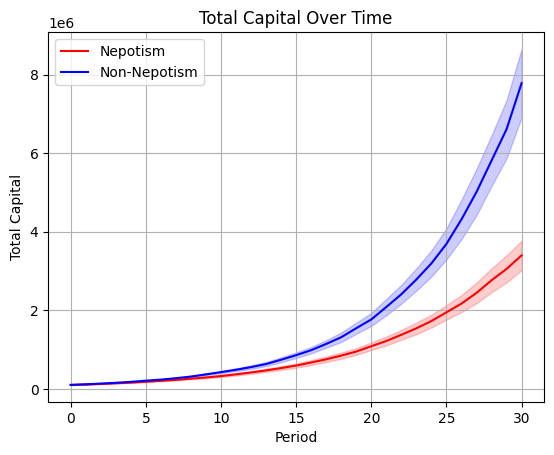

In [2]:
run_scenarios(profit_risk_mag=0.5)

非縁故主義が勝った！ しかし、「普通」の状態と思われる profit_risk_mag=1.0 ではもううまくいかない。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 81072.64
非縁故主義シナリオ 平均最終総資金: 23400.03


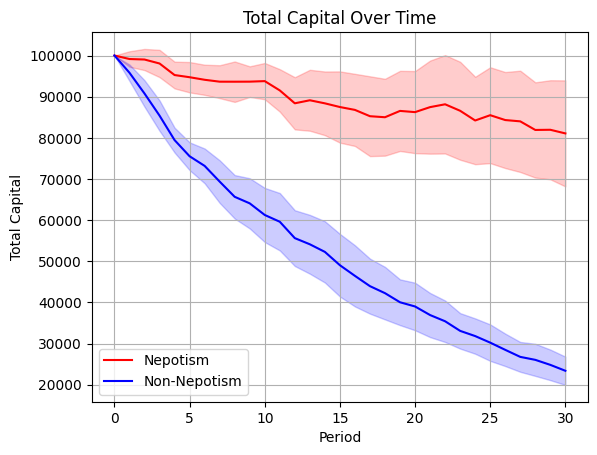

In [3]:
run_scenarios(profit_risk_mag=1.0)

縁故主義が勝ってしまった orz。いちおう、厳しい状況の profit_risk_mag=2.0 も見てみよう。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 153.06
非縁故主義シナリオ 平均最終総資金: 1.85


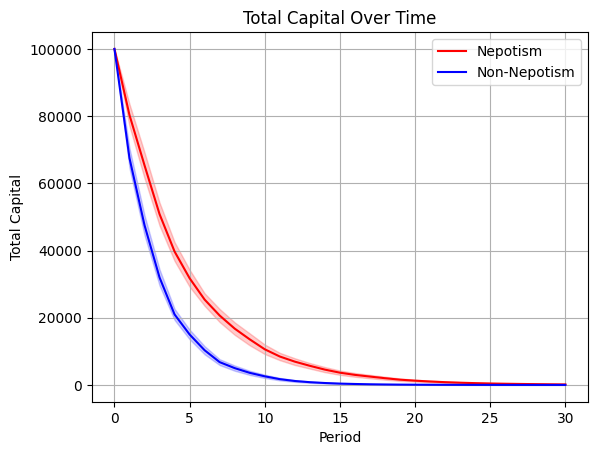

In [4]:
run_scenarios(profit_risk_mag=2.0)

縁故主義の勝利。まるでダメ。

## 実験2

上のあっさりした比較は私が主になった比較で、Gemini さんは分散投資が勝つことにこだわっているようだった。それを示すコードが以下になる。

In [5]:
import random
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

# --- シミュレーションパラメータ ---
RUNS = 20   # シミュレーション実行回数

NUM_INVESTORS = 100  # 投資家数
NUM_BUSINESSES = 200 # 事業数
INITIAL_TOTAL_CAPITAL = 100000 # 経済全体の初期総資金
NUM_PERIODS = 30     # シミュレーション期間（期）

# 事業ごとの投資総額上限の割合 (期首の総資金 / 事業数 に対する倍率)
MAX_BUSINESS_TOTAL_INVESTMENT_RATIO = 1.5

# 事業のリスクとリターンに関するパラメータ
# リスクレベル（0より大きく1以下のランダムな値）
def business_risk_levels ():
    # 全てリスクのある事業とする (リスクの最小値を設定)
    return [random.random() for _ in range(NUM_BUSINESSES)]

# 成功確率 = 1 - リスクレベル
def success_probability (risk_levels):
    return [1 - risk for risk in risk_levels]

# 成功時のリターン倍率 (投資額に対する回収+利益)
# リスクが高いほど成功時のリターンも大きいと仮定
def return_multiplier (risk_levels):
    return [1.0 + risk * 1.5 for risk in risk_levels]

# 投資家の判断に関するパラメータ
# 縁故主義シナリオでの安全投資閾値（このリスク以下の事業に優先投資）
NEPOTISM_SAFE_THRESHOLD = 0.3

# 縁故主義シナリオでのリスク回避度（閾値以上のリスクへの投資を控える度合い）
NEPOTISM_RISK_AVERSION = 1.0 # 1.0は完全に回避

# 非縁故主義シナリオでのリスク許容度（リスクに対する投資意欲の度合い）
# 0に近いほどリスク回避、1に近いほどリスク選好
NON_NEPOTISM_RISK_APPETITE = 0.8

# 非縁故主義シナリオでの分散投資の程度（一度に投資を検討する事業数の上限）
NON_NEPOTISM_CONSIDERATION_LIMIT = 10 # 検討する事業数を設定

# 事業収益環境
PROFIT_RISK_MAG = 0.5  # 0.5:成功しやすい環境, 2.0:成功しにくい環境

# --- シミュレーション関数 ---

def run_simulation(scenario="nepotism"):
    """
    経済シミュレーションを実行する関数

    Args:
        scenario (str): "nepotism" または "non_nepotism"

    Returns:
        list: 各期末の経済全体の総資金のリスト
    """
    total_capital = INITIAL_TOTAL_CAPITAL
    capital_history = [total_capital] # 各期の総資金を記録

    #print(f"--- シナリオ: {scenario} ---")
    #print(f"初期総資金: {total_capital:.2f}")

    # run_scenarios 関数で生成された事業パラメータを使用
    global BUSINESS_RISK_LEVELS, SUCCESS_PROBABILITY, \
        RETURN_MULTIPLIER, PROFIT_RISK_MAG

    for period in range(NUM_PERIODS):
        # 各投資家の利用可能資金を均等に分割（単純化のため）
        investor_capital = total_capital / NUM_INVESTORS \
            if NUM_INVESTORS > 0 else 0
        if investor_capital <= 0:
            print(f"期 {period+1}: 総資金が0以下になりました。"
                  + "シミュレーションを終了します。")
            capital_history.append(total_capital)
            break

        # その期に事業に投資される総額
        period_total_investment = 0
        # 事業ごとの投資受け入れ額
        business_investments = [0] * NUM_BUSINESSES
        # 事業ごとの投資総額上限
        max_business_total_investment = \
            (total_capital / NUM_BUSINESSES) \
            * MAX_BUSINESS_TOTAL_INVESTMENT_RATIO

        # 投資ラウンド
        for investor_id in range(NUM_INVESTORS):
            available_to_invest = investor_capital

            # 投資判断ロジック
            if scenario == "nepotism":
                # 縁故主義シナリオ: 安全な事業を優先し、
                # リスク回避度に応じて高リスクを避ける
                # リスクの低い順に事業をソートして検討
                investable_businesses = sorted(
                    range(NUM_BUSINESSES),
                    key=lambda i: BUSINESS_RISK_LEVELS[i]
                )
                for business_id in investable_businesses:
                    risk = BUSINESS_RISK_LEVELS[business_id]

                    investment_amount = 0
                    # リスク閾値以下の事業に優先投資
                    if risk <= NEPOTISM_SAFE_THRESHOLD:
                        # 低リスク事業には積極的に投資 (リスクが低いほど多く)
                        investment_amount = available_to_invest * (1 - risk)
                    else:
                        # NEPOTISM_RISK_AVERSION = 1.0 の場合、
                        # 閾値以上のリスクには投資しない
                        investment_amount = available_to_invest * (1 - risk) \
                            * (1 - NEPOTISM_RISK_AVERSION)

                    # 事業ごとの投資総額上限を超えないように調整
                    if business_investments[business_id] \
                       + investment_amount > max_business_total_investment:
                        investment_amount = max_business_total_investment\
                            - business_investments[business_id]
                        # 既に最大投資額に達している場合は投資しない
                        if investment_amount < 0:
                            investment_amount = 0

                    if investment_amount > 0:
                         # 利用可能な資金を超えないように調整
                        actual_investment = min(investment_amount,
                                                available_to_invest)
                        business_investments[business_id] += actual_investment
                        period_total_investment += actual_investment
                        available_to_invest -= actual_investment
                        if available_to_invest <= 0:
                            break # 資金が尽きたら次の投資家へ

            elif scenario == "non_nepotism":
                # 非縁故主義シナリオ: より広いリスク範囲に分散投資し、
                # リスクに応じた投資判断
                # 投資可能な事業をランダムに選択し、検討上限まで投資
                potential_businesses = list(range(NUM_BUSINESSES))
                random.shuffle(potential_businesses) # ランダムな順序で検討

                # 検討する事業数を制限
                businesses_to_consider \
                    = potential_businesses[:NON_NEPOTISM_CONSIDERATION_LIMIT]

                for business_id in businesses_to_consider:
                    risk = BUSINESS_RISK_LEVELS[business_id]

                    investment_amount = 0
                    # リスク許容度に応じて投資額を決定
                    # リスクが低いほど多く、
                    # リスクが高いほど少なく投資するが、完全に回避はしない
                    # NON_NEPOTISM_RISK_APPETITE を考慮して投資額を調整
                    investment_amount = available_to_invest \
                        * (1 - risk * (1 - NON_NEPOTISM_RISK_APPETITE))

                    # 事業ごとの投資総額上限を超えないように調整
                    if business_investments[business_id] \
                       + investment_amount > max_business_total_investment:
                        investment_amount = max_business_total_investment \
                            - business_investments[business_id]
                        if investment_amount < 0:
                            investment_amount = 0

                    if investment_amount > 0:
                         # 利用可能な資金を超えないように調整
                        actual_investment = min(investment_amount,
                                                available_to_invest)
                        business_investments[business_id] += actual_investment
                        period_total_investment += actual_investment
                        available_to_invest -= actual_investment
                        if available_to_invest <= 0:
                            break # 資金が尽きたら次の投資家へ


        # 事業の成果判定と資金更新
        period_return = 0 # その期に事業から回収される総額（投資元本＋利益）
        for business_id in range(NUM_BUSINESSES):
            if business_investments[business_id] > 0:
                # 事業が成功するかどうかを確率的に判定
                # PROFIT_RISK_MAG を成功確率に適用
                adjusted_success_prob = SUCCESS_PROBABILITY[business_id] \
                    ** PROFIT_RISK_MAG
                if random.random() < adjusted_success_prob:
                    # 成功した場合：投資額を回収し、リターンを得る
                    period_return += business_investments[business_id] \
                        * RETURN_MULTIPLIER[business_id]
                else:
                    # 失敗した場合：投資額は失われる
                    pass # period_return は増加しない

        # 期末の総資金 = 期首総資金 - その期の総投資額 \
        #    + その期の事業からの総回収額
        total_capital = total_capital - period_total_investment + period_return
        capital_history.append(total_capital)

    #print(f"最終総資金: {total_capital:.2f}")
    return capital_history

# --- シミュレーション実行 ---

def run_scenarios (profit_risk_mag=0.5, runs=RUNS):
    global PROFIT_RISK_MAG
    PROFIT_RISK_MAG = profit_risk_mag

    all_nep, all_non_nep = [], []

    # 各シミュレーション実行ごとに事業パラメータを再生成
    global BUSINESS_RISK_LEVELS, SUCCESS_PROBABILITY, RETURN_MULTIPLIER
    for _ in range(runs):
        BUSINESS_RISK_LEVELS = business_risk_levels()
        SUCCESS_PROBABILITY = success_probability(BUSINESS_RISK_LEVELS)
        RETURN_MULTIPLIER = return_multiplier(BUSINESS_RISK_LEVELS)

        history = run_simulation(scenario="nepotism")
        all_nep.append(history)
        history = run_simulation(scenario="non_nepotism")
        all_non_nep.append(history)
        #print("\n" + "="*30 + "\n") # 区切り線

    # 結果の平均と標準誤差を計算
    mean_nep = np.mean(all_nep, axis=0)
    se_nep = sem(all_nep, axis=0)
    mean_non_nep = np.mean(all_non_nep, axis=0)
    se_non_nep = sem(all_non_nep, axis=0)

    # 結果の比較（簡単な表示）
    print("\n--- シミュレーション結果の比較 ---")
    print(f"縁故主義シナリオ 平均最終総資金: {mean_nep[-1]:.2f}")
    print(f"非縁故主義シナリオ 平均最終総資金: {mean_non_nep[-1]:.2f}")

    # 各期の総資金の推移をグラフなどで可視化する
    plt.figure(figsize=(10, 6)) # グラフサイズを設定
    plt.plot(mean_nep, label='Nepotism', color='red')
    # 95%信頼区間を塗りつぶしで表示 (1.96 * 標準誤差)
    plt.fill_between(range(NUM_PERIODS+1), mean_nep - 1.96*se_nep,
                     mean_nep + 1.96*se_nep, color='red',
                     alpha=0.2)
    plt.plot(mean_non_nep, label='Non-Nepotism', color='blue')
    plt.fill_between(range(NUM_PERIODS+1), mean_non_nep - 1.96*se_non_nep,
                     mean_non_nep + 1.96*se_non_nep, color='blue',
                     alpha=0.2)
    plt.xlabel('Period')
    plt.ylabel('Total Capital')
    plt.title(f'Total Capital Over Time (PROFIT_RISK_MAG = {PROFIT_RISK_MAG})')
    plt.legend()
    plt.grid(True)
    plt.show()


では、よい環境 profit_risk_mag=0.5 で試してみよう。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 519138.32
非縁故主義シナリオ 平均最終総資金: 884536.53


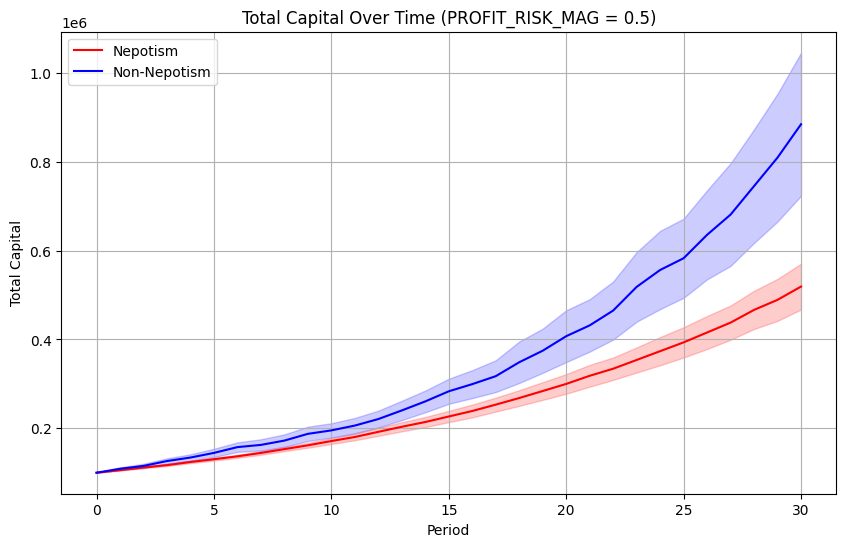

In [6]:
run_scenarios(profit_risk_mag=0.5)

非縁故主義が勝った！

ところがこれは (NEPOTISM_)RISK_AVERSION が 1.0 でリスクの高いところに全く投資しないからこの値が実現する。これを 1.0 未満にするともううまくいかない。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 1459601.06
非縁故主義シナリオ 平均最終総資金: 938070.76


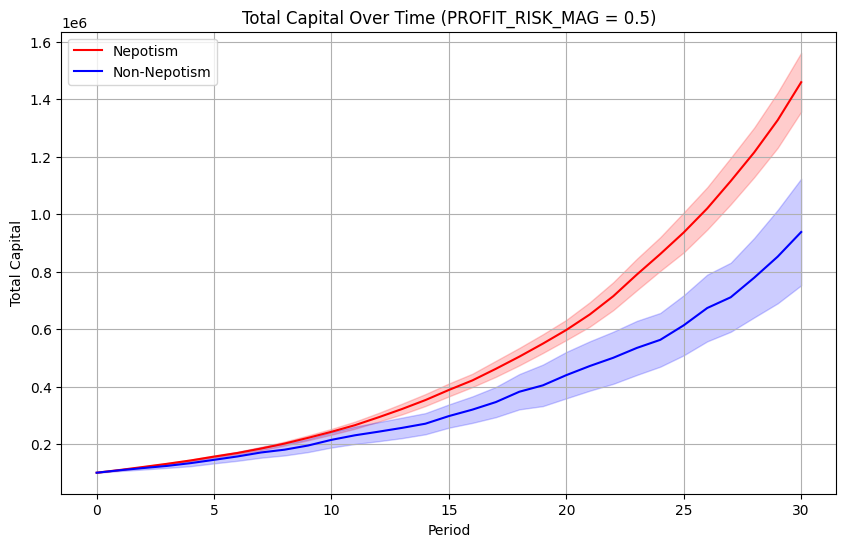

In [7]:
NEPOTISM_RISK_AVERSION = 0.99
run_scenarios(profit_risk_mag=0.5)

当然だが profit_risk_mag=1.0 だとうまくいかない。


--- シミュレーション結果の比較 ---
縁故主義シナリオ 平均最終総資金: 148952.94
非縁故主義シナリオ 平均最終総資金: 28.26


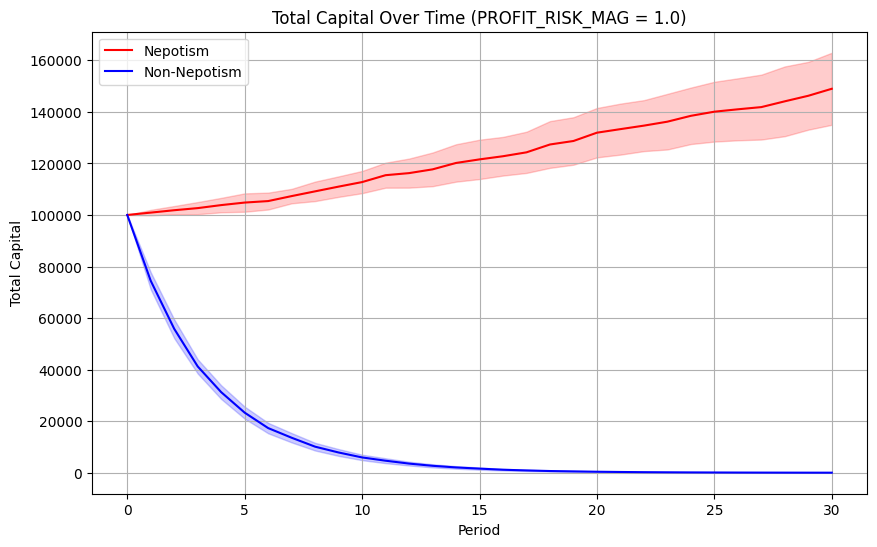

In [8]:
NEPOTISM_RISK_AVERSION = 1.0
run_scenarios(profit_risk_mag=1.0)

profit_risk_mag=2.0 の場合は推して知るべし。

## 結論

縁故主義よりも非縁故主義が有利なことはある。投資環境が良いときはそのようなときがあるようだ。しかし、私が示したかったこととは逆に、投資環境がよほど良くなければ、縁故主義が有利であることが示されてしまった。

残念である。より頑健な結果を得るには、他日を期したい。または他の人におまかせしたい。
